# VIME: Self/Semi Supervised Learning for Tabular Data

# Setup

In [2]:
import sys


In [3]:
sys.path.insert(0, '/home/lic776//Desktop/SIBMI/modified_umap')
directory_to_remove = '/home/lic776/Desktop/SIBMI/vime_refactored'
if directory_to_remove in sys.path:
    print("it is there")
    sys.path.remove(directory_to_remove)
sys.path.append('/home/lic776/Desktop/SIBMI/')
print(sys.path)

import umap as mp


['/home/lic776//Desktop/SIBMI/modified_umap', '/usr/lib64/python36.zip', '/usr/lib64/python3.6', '/usr/lib64/python3.6/lib-dynload', '', '/home/lic776/Desktop/SIBMI/.venv/lib64/python3.6/site-packages', '/home/lic776/Desktop/SIBMI/.venv/lib/python3.6/site-packages', '/home/lic776/Desktop/SIBMI/.venv/lib64/python3.6/site-packages/IPython/extensions', '/home/lic776/.ipython', '/home/lic776/Desktop/SIBMI/']


Using TensorFlow backend.


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import importlib_metadata
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import (average_precision_score, mean_squared_error,
                             roc_auc_score)
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from vime_refactored.vime import VIME, VIME_Self
from vime_refactored.vime_data import (
    labelled_loss_fn, mask_generator_tf,
    pretext_generator_tf, semi_supervised_generator,
    to_vime_dataset, unlabelled_loss_fn
)
from sklearn.preprocessing import LabelEncoder
import copy


In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = (20,10)

# Data

We're going to be using IEEE-CIS Fraud detection dataset from Kaggle. The dataset was already pre-processed and can be downloaded from [Kaggle](https://www.kaggle.com/datasets/antonsruberts/fraud-detection-preprocesed). If you want to know about the pre-processing process or yopu want to change something, feel free to take a look at the `Fraud Data Unsupervised Preprocessing` notebook.
The example data is taken from [Kaggle](https://www.kaggle.com/c/ieee-fraud-detection) but it's already pre-processed and ready to be used. You can checkout the pre-processing notebook in the same folder to get some understanding about what transformations were done to the features.

In [6]:
df = pd.read_csv('/home/lic776/Desktop/SIBMI/merged_data_sub_10.csv')

# Further preparing the data 
# Drop irrelevant columns
columns_to_drop = ["SDMVPSU", "SDMVSTRA", "WTMEC4YR", "SDDSRVYR", "RIDSTATR", "WTSCY4YR"] # "eGFR", "eGFR_no_race", "change_in_eGFR"]
df = df.drop(columns=columns_to_drop)
# Encode categorical variables
label_encoders = {}
for column in ["RIAGENDR", "RIDRETH2", "RIDEXPRG"]:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column].astype(str))
    label_encoders[column] = le

# separating and printing shapes
labeled_data = df[df['simulated_mGFR'].notna()]
unlabeled_data = df[df['simulated_mGFR'].isna()]

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# from semisupervised.ipynb, but we actually want X
X_labeled = labeled_data.drop(columns=['simulated_mGFR'])
y_labeled = labeled_data['simulated_mGFR']
X_unlabeled = unlabeled_data.drop(columns=['simulated_mGFR'])

X = pd.concat([X_labeled, X_unlabeled], ignore_index=True)

print(X.shape)

(4262, 51)


In [7]:
my_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="mean")),
    ('std_scaler', StandardScaler())
])




# Splitting X into training and test sets for labeled data
X_train_labeled, X_test_labeled, y_train_labeled, y_test_labeled = train_test_split(X_labeled, y_labeled, test_size=0.2, random_state=42)

# # Fit and transform X_train_labeled
X_train_labeled = my_pipeline.fit_transform(X_train_labeled)
X_train_labeled = pd.DataFrame(X_train_labeled)

# Transform X_test_labeled and X_unlabeled
X_test_labeled= my_pipeline.transform(X_test_labeled)
X_test_labeled_ = pd.DataFrame(X_test_labeled)
X_unlabeled = my_pipeline.transform(X_unlabeled)
X_unlabeled = pd.DataFrame(X_unlabeled)

print(X_train_labeled.shape, X_test_labeled.shape)


(340, 51) (86, 51)


In [8]:
# val? 
X_train_labeled_copy = copy.deepcopy(X_train_labeled)
y_train_labeled_copy = copy.deepcopy(y_train_labeled)
X_train_labeled, X_val_labeled, y_train_labeled, y_val_labeled = train_test_split(X_train_labeled_copy, y_train_labeled_copy, test_size=0.1, random_state=42)
X_train_unlabeled, X_val_unlabeled = train_test_split(X_unlabeled, test_size=0.1, random_state=42)

print("Labelled train, val, test: ", X_train_labeled.shape, X_val_labeled.shape, X_test_labeled.shape)
print("unlabelled train, val: ", X_train_unlabeled.shape, X_val_unlabeled.shape)
print("X_unlabeled: ", X_unlabeled.shape)
print(
    "Labelled Proportion:", 
    np.round((X_train_labeled.shape[0]) / (X_unlabeled.shape[0] + X_train_labeled.shape[0]), 5)
) # should be .07388

Labelled train, val, test:  (306, 51) (34, 51) (86, 51)
unlabelled train, val:  (3452, 51) (384, 51)
X_unlabeled:  (3836, 51)
Labelled Proportion: 0.07388


The following model will be trained with these hyperparameters:

In [9]:
vime_params = {
    'alpha': 10, # importance of feature loss = more diverse
    'beta': 5,  # importance of mask loss
    'k': 5, 
    'p_m': 0.36
}

## Self-Supervised Learning

### Data Prep

The model needs 1 input - corrupted X, and 2 outputs - mask and original X. 

In [10]:
print(np.any(np.isnan(X_train_unlabeled)))
print(np.any(np.isinf(X_train_unlabeled)))
print(np.any(np.isnan(X_val_unlabeled)))
print(np.any(np.isinf(X_val_unlabeled)))

zero_variance_features = (X_train_unlabeled.var() == 0).sum()
if zero_variance_features > 0:
    print(f"Warning: {zero_variance_features} features have zero variance.")



False
False
False
False


In [11]:
batch_size = 32

# Datasets
train_ds, train_m = to_vime_dataset(X_train_unlabeled, vime_params['p_m'], batch_size=batch_size, shuffle=True)
val_ds, val_m = to_vime_dataset(X_val_unlabeled, vime_params['p_m'], batch_size=batch_size)
num_features = X_train_unlabeled.shape[1]

print('Proportion Corrupted:', np.round(train_m.numpy().mean(), 2))

# Training
vime_s = VIME_Self(num_features)
vime_s.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss={
        'mask': 'binary_crossentropy', 
        'feature': 'mean_squared_error'},
    loss_weights={'mask':1, 'feature': vime_params['alpha']}
)

cbs = [tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )]

vime_s.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1000,
    callbacks=cbs
)

vime_s.save('./vime_self')

AttributeError: module 'tensorflow.python.keras.api._v1.keras.backend' has no attribute 'random_bernoulli'

In [12]:
vime_s = tf.keras.models.load_model('./vime_self')

### Evaluation

All the evaluation will be done on the validation set

In [13]:
val_self_preds = vime_s.predict(val_ds)

To evaluate the mask reconstruction ability we can simply check the ROC AUC score for mask predictions across all the features. 

In [14]:
feature_aucs = []
for i in tqdm(range(X_val_unlabeled.shape[1])):
    roc = roc_auc_score(val_m.numpy()[:, i], val_self_preds['mask'][:, i])
    feature_aucs.append(roc)

  0%|          | 0/51 [00:00<?, ?it/s]

100%|██████████| 51/51 [00:00<00:00, 447.68it/s]


In [15]:
print(feature_aucs)

[0.5136003183355597, 0.769910888331941, 0.5175315568022439, 0.5571631878557876, 0.5778546712802768, 0.5118416618156194, 0.5477802628757009, 0.4851251570207421, 0.548230803112612, 0.4813902885936785, 0.505523681640625, 0.568115234375, 0.533477783203125, 0.53007769145394, 0.5734198579909208, 0.5037611940298508, 0.5438604797979798, 0.48007268322228946, 0.5346134259952671, 0.4600205549845837, 0.5655058983666061, 0.49939419013564235, 0.5523212860900146, 0.5095451993262212, 0.58148193359375, 0.5778921865536039, 0.5591793168880456, 0.4679566305254379, 0.5295226722810547, 0.5314771035811225, 0.5231243576567317, 0.5354330708661417, 0.495581477553906, 0.5325526932084309, 0.48100117096018735, 0.4719073359073359, 0.43516414141414145, 0.5195984555984556, 0.5210555867490174, 0.5287247474747475, 0.7599196383726771, 0.6670983337650005, 0.7134770564856077, 0.8250878955298845, 0.46626099146170513, 0.5317149792945881, 0.5521972261330618, 0.5007282593174354, 0.6920444174018863, 0.5164986672385796, 0.49872

In [16]:
self_metrics = pd.DataFrame({"metric": 'mask_auc', 
             "metric_values": feature_aucs})

Now, we can evaluate the feature reconstruction ability using RMSE and correlation coefficients

In [17]:
input_feature_variances = np.var(X_val_unlabeled.values, axis=0)
print("Input Feature Variances:", input_feature_variances)

# Calculate variances for predicted features
predicted_feature_variances = np.var(val_self_preds['feature'], axis=0)
print("Predicted Feature Variances:", predicted_feature_variances)

# Check if any input features have zero variance
zero_variance_input_features = np.sum(input_feature_variances == 0)
print(f"Number of input features with zero variance: {zero_variance_input_features}")

# Check if any predicted features have zero variance = model not learning useful representatois
zero_variance_predicted_features = np.sum(predicted_feature_variances == 0)
print(f"Number of predicted features with zero variance: {zero_variance_predicted_features}")

# Compute feature correlations, handling potential issues
feature_corrs = []
for i in tqdm(range(X_val_unlabeled.shape[1])):
    feature = X_val_unlabeled.values[:, i]
    pred_feature = val_self_preds['feature'][:, i]
    
    # Check for zero variance in feature or predicted feature
    if np.var(feature) == 0:
        print(f"Feature {i} var 0 in input")
        c = np.nan 
    elif np.var(pred_feature) == 0:
        print(f"Feature {i} var 0 in predictions")
        c = np.nan  # Assign NaN if variance is zero
    else:
        c = np.corrcoef(feature, pred_feature)[0, 1]
    feature_corrs.append(c)
    
self_metrics = pd.concat([
    self_metrics,
    pd.DataFrame({"metric": 'feature_correlation', 
             "metric_values": feature_corrs})
])

Input Feature Variances: [1.16522322 1.07327946 1.01392506 0.89348693 0.98376629 0.88311837
 0.88311837 0.298112   0.36550703 0.67576127 0.61159076 0.61147459
 1.12293132 1.12293132 1.13910682 1.13840739 1.17011885 2.64022837
 0.62725405 0.62725967 0.89443342 0.8944523  0.80402999 1.00871042
 1.00984647 1.23031177 1.23167011 0.95594694 0.95594694 0.7148636
 0.71483385 0.79870448 0.79872398 0.69444951 1.21589875 0.88359092
 1.05032396 1.07630963 0.88258804 0.88258804 1.66453083 1.66453083
 0.93080668 0.93080668 0.79718774 0.67039593 0.80915833 0.80319041
 0.84790618 0.87498147 1.17199355]
Predicted Feature Variances: [0.1462291  0.03831572 0.15646093 0.12989496 0.1186801  0.1371773
 0.13597013 0.03671154 0.03605137 0.05457707 0.07790788 0.08008123
 0.12062636 0.12114664 0.16643815 0.16470657 0.14525877 0.0710437
 0.06198777 0.05947344 0.10591778 0.10614669 0.08865851 0.11966839
 0.11805584 0.11944082 0.11970175 0.12327585 0.12222075 0.11171514
 0.11235946 0.13221171 0.13110368 0.0358080

100%|██████████| 51/51 [00:00<00:00, 2796.68it/s]


From the plot and table above, we can see that the model has learned to reconstruct most of the features. Half of the features are reconstructed with relatively strong correlation with original data. Only a handful of features are not properly reconstructed. Let's check the RMSE across all the features

In [18]:
rmses = []
for i in tqdm(range(X_val_unlabeled.shape[1])):
    mse = mean_squared_error(X_val_unlabeled.values[:, i], val_self_preds['feature'][:, i])
    rmses.append(np.sqrt(mse))
    
self_metrics = pd.concat([
    self_metrics,
    pd.DataFrame({"metric": 'RMSE', 
             "metric_values": rmses})
])

100%|██████████| 51/51 [00:00<00:00, 2775.13it/s]


In [19]:
print(rmses)

[0.9730245984662603, 0.9871163424622142, 0.9152239649001827, 0.8180491520050547, 0.8553137859645138, 0.8340840247436042, 0.8340245457559087, 0.5085324338475601, 0.5684377698831602, 0.7675077351058984, 0.648861117810523, 0.648205433193068, 0.9302559704460742, 0.9304713213858548, 0.8742515295116375, 0.8716479276309653, 0.9576005069917204, 1.497730566413078, 0.670608942100125, 0.6684568103716653, 0.8383086392688012, 0.8426601899838807, 0.808640386771402, 0.8819490712699274, 0.8821657701808758, 0.9513406733757521, 0.9528683502614629, 0.8413865121855787, 0.839926154290656, 0.699398559190768, 0.6991076340038613, 0.7702412520265857, 0.769165948450586, 0.7483859872800835, 1.0427897196050204, 0.8491654045096964, 0.9790789337339991, 0.952127157407213, 0.799835025358913, 0.8008128981486036, 1.190114958567077, 1.1894301501795828, 0.904472995557334, 0.9063569974781075, 0.756585490278752, 0.7347693195276122, 0.7871914601693437, 0.7847004849774168, 0.8704874595830915, 0.8205894069664054, 0.9757914009

Text(0.5, 1.0, 'Self-Supervised VIME Evaluation')

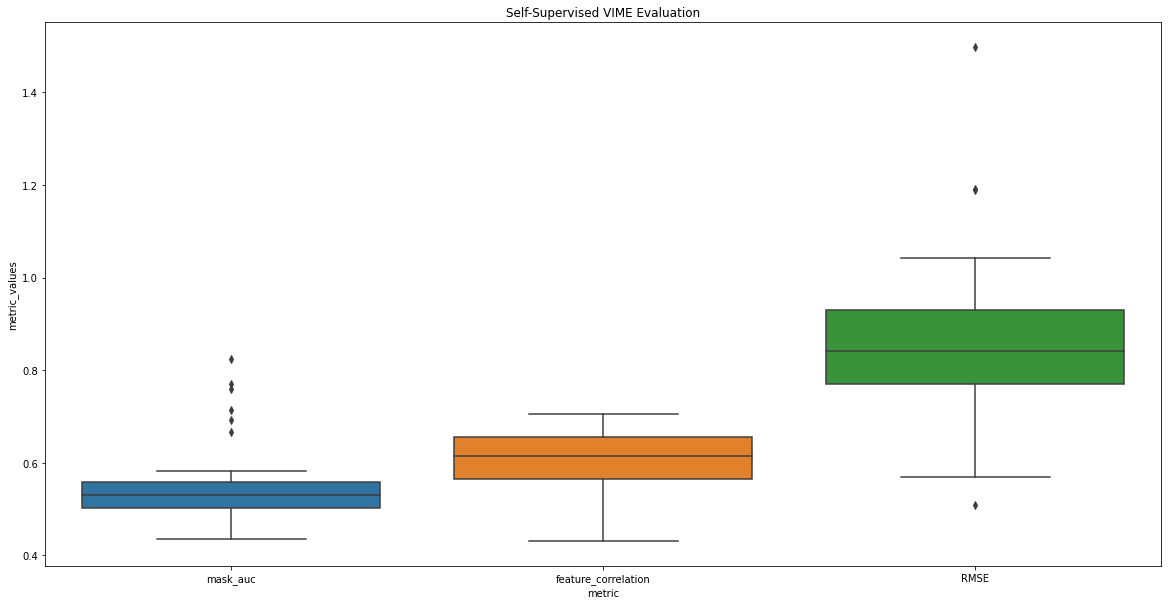

In [20]:
sns.boxplot(x=self_metrics['metric'], y=self_metrics['metric_values'])
plt.title("Self-Supervised VIME Evaluation")

RMSE distribution further indicates that mjority of the features are well-reconstructed.

Another way to evaluate the self-supervised model is to look at the embeddings. Since the whole point of corrupting the dataset is to learn to generate robust embeddings, we can assume that if a sample was corrupted 5 times, all 5 embeddings should be relatively close to each other in the vector space. Let's check this hypothesis by corrupting 10 different samples 5 times and projecting their embeddings to 2-dimensional space using UMAP.

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout


def generate_k_corrupted(x, k, p_m):
    x_u_list = []
    for i in range(k):
        mask = mask_generator_tf(p_m, x)
        _, x_corr = pretext_generator_tf(mask, tf.constant(x, dtype=tf.float32))
        x_u_list.append(x_corr)
    
    
    # Prepare input with shape (n, k, d)
    x_u_corrupted = np.zeros((x.shape[0], k, x.shape[1]))
    for i in range(x.shape[0]):
        for j in range(k):
            x_u_corrupted[i, j, :] = x_u_list[j][i, :]
    
    return x_u_corrupted

In [22]:
vime_s = tf.keras.models.load_model('./vime_self')

# Sequential model to produce embeddings
encoding_model = Sequential(
    [
        Input(num_features),
        vime_s.encoder
    ]
)

dense_model = Sequential(
    [
        Input(num_features),
        Dense(num_features, activation="relu"),
    
    ]
)

# Create corrupted sample
samples = X_val_unlabeled.sample(10)
sample_corrupted = generate_k_corrupted(
    x=samples,
    k=5,
    p_m=0.4
)

val_encoding = encoding_model.predict(sample_corrupted, batch_size=batch_size)
random_encoding = dense_model.predict(sample_corrupted, batch_size=batch_size)

/home/lic776/Desktop/SIBMI/.venv/lib64/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
No handles with labels found to put in legend.
/home/lic776/Desktop/SIBMI/.venv/lib64/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


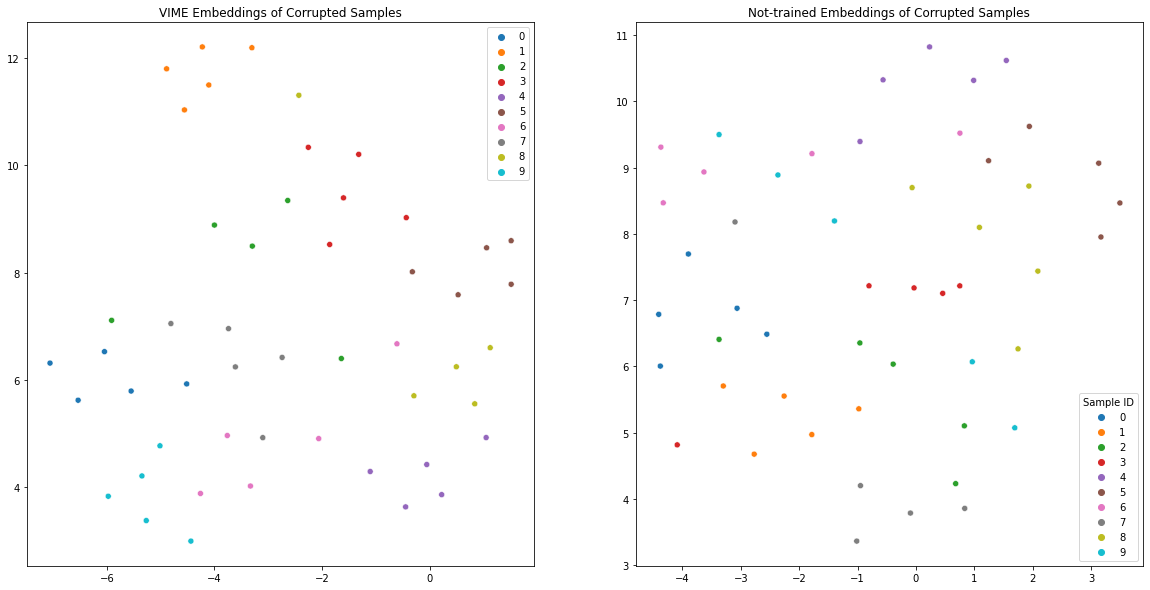

In [23]:
import umap

fig, axs = plt.subplots(1, 2)

# Project corrupted samples
u = umap.UMAP(n_neighbors=5, min_dist=0.8)
corrupted_umap = u.fit_transform(val_encoding.reshape(-1, val_encoding.shape[2]))
sample_ids = np.array([np.repeat(i, 5) for i in range(10)]).ravel()
sns.scatterplot(corrupted_umap[:, 0], corrupted_umap[:, 1], hue=sample_ids, palette="tab10", ax=axs[0])
axs[0].set_title('VIME Embeddings of Corrupted Samples')
plt.legend(title='Sample ID')

# Project corrupted samples
u = umap.UMAP(n_neighbors=5, min_dist=0.8)
corrupted_umap = u.fit_transform(random_encoding.reshape(-1, random_encoding.shape[2]))
sample_ids = np.array([np.repeat(i, 5) for i in range(10)]).ravel()
sns.scatterplot(corrupted_umap[:, 0], corrupted_umap[:, 1], hue=sample_ids, palette="tab10", ax=axs[1])
axs[1].set_title('Not-trained Embeddings of Corrupted Samples')

plt.legend(title='Sample ID')
plt.show()

As you can see, the embeddings indeed put the same samples closer to each other, even though some of their values were corrupted. According to the authors, this means that the model has learned useful information about the feature correlations which can be helpful in the downstream tasks. Now, we can use this encoder in the next semi-supervised part.

## Semi-Supervised Learning

In [24]:
semi_batch_size = 512
num_features = X_train_unlabeled.shape[1]

Since we have different number of labelled and unlabelled examples we need to use generators. They will shuffle and select appropriate number of rows for each training iteration.

In [25]:
def train_semi_generator():
    return semi_supervised_generator(
        X_train_labeled.values,
        X_train_unlabeled.values, 
        y_train_labeled.values, 
        bs=semi_batch_size
    )

def val_semi_generator():
    return semi_supervised_generator(
        X_val_labeled.values,
        X_val_unlabeled.values, 
        y_val_labeled.values, 
        bs=semi_batch_size
    )

semi_train_dataset = tf.data.Dataset.from_generator(
     train_semi_generator,
     output_signature=(
         tf.TensorSpec(shape=(semi_batch_size, num_features), dtype=tf.float32),
         tf.TensorSpec(shape=(semi_batch_size), dtype=tf.float32),
         tf.TensorSpec(shape=(semi_batch_size, num_features), dtype=tf.float32)
     )
)

semi_val_dataset = tf.data.Dataset.from_generator(
     val_semi_generator,
     output_signature=(
         tf.TensorSpec(shape=(semi_batch_size, num_features), dtype=tf.float32),
         tf.TensorSpec(shape=(semi_batch_size), dtype=tf.float32),
         tf.TensorSpec(shape=(semi_batch_size, num_features), dtype=tf.float32)
     )
)

## Self Supervised VIME

In [32]:
def train_vime_semi(encoder, train_dataset, val_dataset, train_params, vime_params):
    # Model
    import numpy as np 

    vime = VIME(encoder)
    
    # Training parameters
    iterations = train_params['iterations']
    optimizer = tf.keras.optimizers.Adam(train_params['learning_rate'])
    early_stop = train_params['early_stop']
    
    # Set metrics to track
    best_loss = 1e10
    no_improve = 0
    
    # Begining training loop
    for it in range(iterations):
        # Grab a batch for iteration
        it_train = iter(train_dataset)
        X_l, y_l, X_u = next(it_train)
        
        # Generate unlabelled batch with k corrupted examples per sample
        X_u_corrupted = generate_k_corrupted(X_u, vime_params['k'], vime_params['p_m'])
        
        with tf.GradientTape() as tape:
            # Predict labelled & unlabelled
            labelled_preds = vime(X_l)
            unlabelled_preds = vime(X_u_corrupted)

            # Calculate losses
            labelled_loss = labelled_loss_fn(y_l, labelled_preds)
            unlabelled_loss = unlabelled_loss_fn(unlabelled_preds)

            # Total loss
            semi_supervised_loss = unlabelled_loss + vime_params['beta'] * labelled_loss
        
        if it % 10 == 0:
            val_iter_losses = []
            print(f"\nMetrics for Iteration {it}")
            for i in range(5):
                # Grab a batch
                it_val = iter(val_dataset)
                X_l_val, y_l_val, X_u_val = next(it_val)

                # Generate unlabelled batch with k corrupted examples per sample
                X_u_corrupted = generate_k_corrupted(X_u_val, vime_params['k'], vime_params['p_m'])

                # Predict labelled & unlabelled
                labelled_preds_val = vime(X_l_val)
                unlabelled_preds_val = vime(X_u_corrupted)

                # Calculate losses
                labelled_loss_val = labelled_loss_fn(y_l_val, labelled_preds_val)
                unlabelled_loss_val = unlabelled_loss_fn(unlabelled_preds_val)
                semi_supervised_loss_val = unlabelled_loss_val + vime_params['beta'] * labelled_loss_val
                val_iter_losses.append(semi_supervised_loss_val)
            
            # Average loss over 5 validation iterations
            semi_supervised_loss_val = np.mean(val_iter_losses)

            print(f"Train Loss {np.round(semi_supervised_loss, 5)}, Val Loss {np.round(semi_supervised_loss_val, 5)}")
            # Update metrics if val_loss is better
            if semi_supervised_loss_val < best_loss:
                best_loss = semi_supervised_loss_val
                no_improve = 0
                vime.save('./vime')
            else:
                no_improve += 1
                print(f"Validation loss not improved {no_improve} times")

            # Early stopping
            if no_improve == early_stop:
                break
        
        # Update weights
        grads = tape.gradient(semi_supervised_loss, vime.trainable_weights)
        optimizer.apply_gradients(zip(grads, vime.trainable_weights))

    vime = tf.keras.models.load_model('./vime')

    return vime

In [31]:
import sys
print(sys.path)

['/home/lic776//Desktop/SIBMI/modified_umap', '/usr/lib64/python36.zip', '/usr/lib64/python3.6', '/usr/lib64/python3.6/lib-dynload', '', '/home/lic776/Desktop/SIBMI/.venv/lib64/python3.6/site-packages', '/home/lic776/Desktop/SIBMI/.venv/lib/python3.6/site-packages', '/home/lic776/Desktop/SIBMI/.venv/lib64/python3.6/site-packages/IPython/extensions', '/home/lic776/.ipython']


In [34]:
train_params = {
    'num_features': num_features,
    'iterations': 1000,
    'early_stop': 20,
    'learning_rate': 0.001
}

vime_self = tf.keras.models.load_model('./vime_self')

vime_semi = train_vime_semi(
    encoder = vime_self.encoder,
    train_dataset = semi_train_dataset, 
    val_dataset = semi_val_dataset,
    train_params = train_params,
    vime_params = vime_params
)



Metrics for Iteration 0
Train Loss -221.58859252929688, Val Loss -241.93582153320312
INFO:tensorflow:Assets written to: ./vime/assets

Metrics for Iteration 10
Train Loss -4968.064453125, Val Loss -4839.07958984375
INFO:tensorflow:Assets written to: ./vime/assets

Metrics for Iteration 20
Train Loss -6288.2587890625, Val Loss -5845.5556640625
INFO:tensorflow:Assets written to: ./vime/assets

Metrics for Iteration 30
Train Loss -6236.025390625, Val Loss -5928.04248046875
INFO:tensorflow:Assets written to: ./vime/assets


Exception ignored in: <bound method IteratorResourceDeleter.__del__ of <tensorflow.python.data.ops.iterator_ops.IteratorResourceDeleter object at 0x7f515810cb08>>
Traceback (most recent call last):
  File "/home/lic776/Desktop/SIBMI/.venv/lib64/python3.6/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/home/lic776/Desktop/SIBMI/.venv/lib64/python3.6/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 
Exception ignored in: <bound method IteratorResourceDeleter.__del__ of <tensorflow.python.data.ops.iterator_ops.IteratorResourceDeleter object at 0x7f5158141fc8>>
Traceback (most recent call last):
  File "/home/lic776/Desktop/SIBMI/.venv/lib64/python3.6/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/home/lic77


Metrics for Iteration 40
Train Loss -6249.90673828125, Val Loss -5854.51953125
Validation loss not improved 1 times

Metrics for Iteration 50
Train Loss -6203.6669921875, Val Loss -5933.22900390625
INFO:tensorflow:Assets written to: ./vime/assets

Metrics for Iteration 60
Train Loss -6153.96142578125, Val Loss -5877.44384765625
Validation loss not improved 1 times

Metrics for Iteration 70


Exception ignored in: <bound method IteratorResourceDeleter.__del__ of <tensorflow.python.data.ops.iterator_ops.IteratorResourceDeleter object at 0x7f5158398848>>
Traceback (most recent call last):
  File "/home/lic776/Desktop/SIBMI/.venv/lib64/python3.6/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/home/lic776/Desktop/SIBMI/.venv/lib64/python3.6/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


Train Loss -6149.41357421875, Val Loss -5840.2490234375
Validation loss not improved 2 times


In [28]:
test_ds = tf.data.Dataset.from_tensor_slices(test[num_cols]).batch(batch_size)

vime_tuned_preds = vime_semi.predict(test_ds)
pr = average_precision_score(test['isFraud'], vime_tuned_preds)
print(pr)

NameError: name 'test' is not defined

## Evaluation

Re-training the model 10 times to get distribution of PR AUC scores.

In [247]:
vime_prs = []
test_ds = tf.data.Dataset.from_tensor_slices(test[num_cols]).batch(batch_size)

for i in range(10):
    train_params = {
        'num_features': num_features,
        'iterations': 1000,
        'early_stop': 10,
        'learning_rate': 0.001
    }
    vime_self = tf.keras.models.load_model('./vime_self')
    vime_self.encoder.trainable = False
    vime_semi = train_vime_semi(
        encoder = vime_self.encoder,
        train_dataset = semi_train_dataset, 
        val_dataset = semi_val_dataset,
        train_params = train_params,
        vime_params = vime_params
    )
    # fine-tune
    vime_semi = tf.keras.models.load_model('./vime')
    vime_semi.encoder.trainable


    vime_tuned_preds = vime_semi.predict(test_ds)
    pr = average_precision_score(test['isFraud'], vime_tuned_preds)
    vime_prs.append(pr)
    print('VIME Train', i, "PR AUC:", pr)

### Compare with MLP and RF

In [ ]:
mlp_prs = []

for i in range(10):
    base_mlp = Sequential([
        Input(shape=num_features),
        Dense(num_features),
        Dense(128),
        Dropout(0.2),
        Dense(128),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    base_mlp.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy'
    )

    # Early stopping based on validation loss    
    cbs = [tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=20, restore_best_weights=True
        )]

    base_mlp.fit(
        x=X_train_labelled.values,
        y=y_train_labelled,
        validation_data=(X_val_labelled.values, y_val_labelled),
        epochs=1000,
        callbacks=cbs
    )

    base_mlp_preds = base_mlp.predict(test_ds)
    mlp_prs.append(average_precision_score(test['isFraud'], base_mlp_preds))

In [231]:
from lightgbm import LGBMClassifier

train_tree_X = pd.concat([X_train_labelled, X_val_labelled])
train_tree_y = pd.concat([y_train_labelled, y_val_labelled])

rf_prs = []
for i in tqdm(range(10)):
    rf = RandomForestClassifier(max_depth=4)
    rf.fit(train_tree_X.values, train_tree_y)
    rf_preds = rf.predict_proba(test[X_train_labelled.columns])
    rf_prs.append(average_precision_score(test['isFraud'], rf_preds[:, 1]))

100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


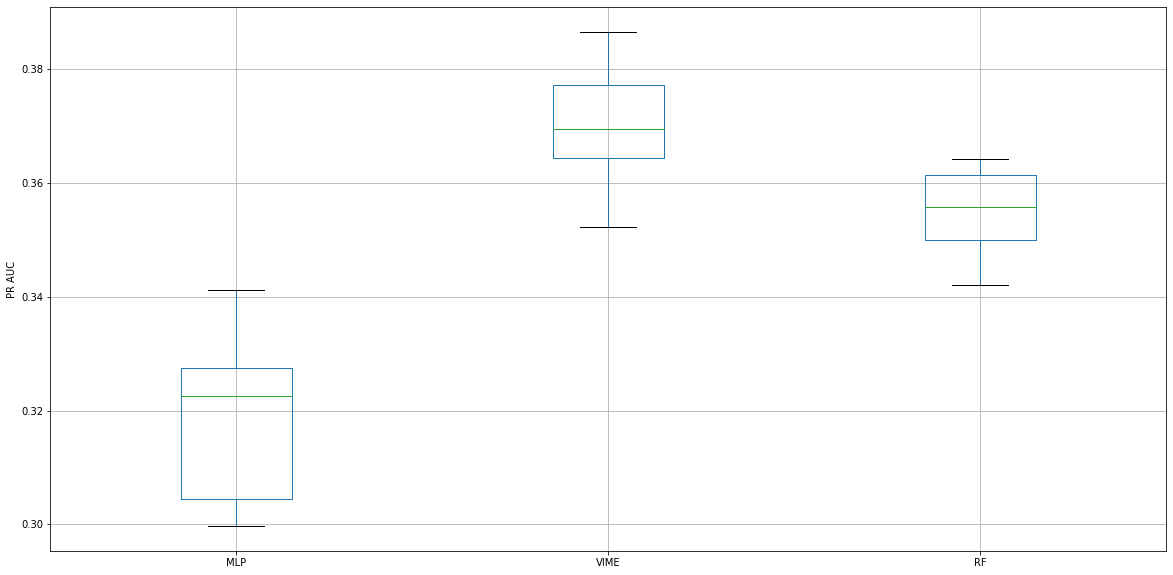

In [235]:
metrics_df = pd.DataFrame({"MLP": mlp_prs,
             "VIME": vime_prs,
             "RF": rf_prs})

metrics_df.boxplot()
plt.ylabel("PR AUC")
plt.show()

In [236]:
metrics_df.describe()

,MLP,VIME,RF
count,10.000000,10.000000,10.000000
mean,0.318847,0.370264,0.354883
std,0.014776,0.010052,0.007481
min,0.299667,0.352266,0.341996
25%,0.304485,0.364469,0.349961
50%,0.322631,0.369486,0.355842
75%,0.327522,0.377327,0.361452
max,0.341173,0.386599,0.364158
